In [1]:
# import all necessary packages
import glob
import pickle
import warnings

import numpy as np
import pandas as pd

from drugpk.training.scorers.predictors import Predictor

from sklearn.preprocessing import MinMaxScaler as Scaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import metrics

from rdkit import Chem
from rdkit.Chem import PandasTools

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl

#set plot text color
COLOR = '#001158'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

import seaborn as sns

from collections import defaultdict

from rdkit.SimDivFilters.rdSimDivPickers import LeaderPicker
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
import cairosvg


base_dir = "Lombardo_set"

/home/helle/.conda/envs/PK/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


          Train  Test
property             
CL         1071   185
VDss       1065   159


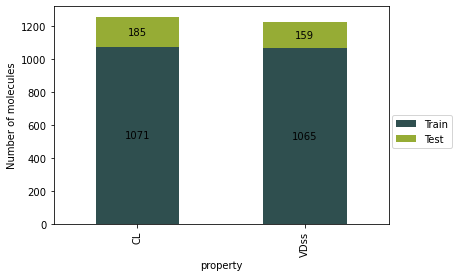

In [5]:
### plot train and test set size

my_cmap = ListedColormap(["darkslategrey", "#96AC35"])

fnames = glob.glob(f'{base_dir}/envs/*QSKRdata.pkg')
fnames = [fname for fname in fnames if ("CL" in fname) or ("VDss" in fname)]

data_objs = [pickle.load(open(fname, 'rb')) for fname in fnames]

data = np.array([[data_obj.property, data_obj.X.shape[0], data_obj.X_ind.shape[0]] for data_obj in data_objs if data_obj.reg])
TrainTestSize = pd.DataFrame(data = data,
             columns=["property", "Train", "Test"]).set_index("property").astype('int64')

ax = TrainTestSize.plot(kind='bar', stacked=True, ylabel='Number of molecules', cmap=my_cmap)

for container in ax.containers:
    ax.bar_label(container, label_type='center')

lgd = plt.legend(bbox_to_anchor=(1.01, 0.5), loc='upper left', borderaxespad=0)

plt.savefig(f"{base_dir}/figures/dataset/traintest.png", dpi=300, bbox_extra_artists=(lgd,ax), bbox_inches='tight')
print(TrainTestSize)

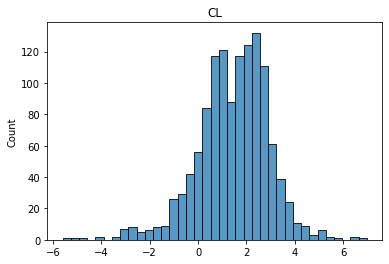

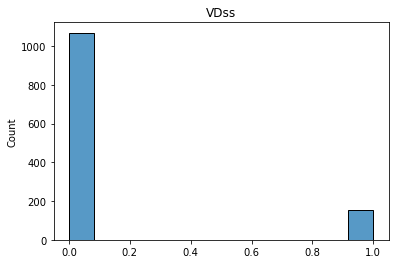

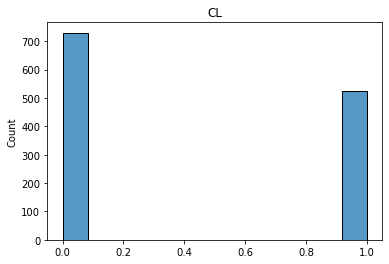

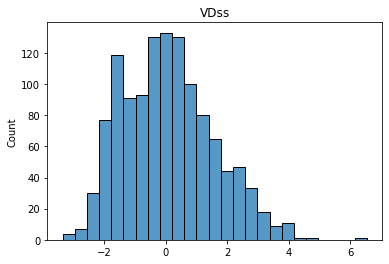

In [6]:
### plot data distribution

my_cmap = ListedColormap(["darkslategrey", "#96AC35"])

fnames = glob.glob(f'{base_dir}/envs/*QSKRdata.pkg')
fnames = [fname for fname in fnames if ("CL" in fname) or ("VDss" in fname)]

data_objs = [pickle.load(open(fname, 'rb')) for fname in fnames]

for data in data_objs:
    y_all = np.concatenate([data.y, data.y_ind], axis=0)
    sns.histplot(data=y_all)
    plt.title(data.property)
    plt.savefig(f"{base_dir}/figures/dataset/{data.property}_distribtion.png", dpi=300, bbox_inches='tight')
    plt.show()
    

In [ ]:

warnings.filterwarnings(action='ignore', category=FutureWarning)

def dataset_pca(data, out, alg = "TSNE"):

    X_all = np.concatenate([data.X, data.X_ind], axis=0)
    y_all = np.concatenate([data.y, data.y_ind], axis=0)
    traintest = np.concatenate([['train']*len(data.y), ['test']*len(data.y_ind)], axis=0)
    
    fps = Scaler().fit_transform(X_all)
    red_alg = PCA(n_components=2) if alg == 'PCA' else TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30, metric='jaccard')
    xy = red_alg.fit_transform(fps)

    plt.figure()
    comp_X, comp_Y = xy[:, 0], xy[:, 1]
    sns.scatterplot(x=comp_X, y=comp_Y, hue=traintest)
    plt.title(f"{alg} of train versus test set for {data.property}")
    plt.savefig(f"{out}/{alg}_{data.property}_by_dataset.png")
    plt.show()

    plt.figure()
    Xtsne, Ytsne = xy[:, 0], xy[:, 1]
    sns.scatterplot(x=comp_X, y=comp_Y, hue=y_all, palette = sns.color_palette("crest", as_cmap=True))
    plt.title(f"{alg} for {data.property} colored by value")
    plt.savefig(f"{out}/{alg}_{data.property}_by_pChembl.png")
    plt.show()
    # plt.close()

fnames = glob.glob(f'{base_dir}/envs/*QSKRdata.pkg')
fnames = [fname for fname in fnames if ("CL" in fname) or ("VDss" in fname)]
for fname in fnames:
    if "REG" in fname:
        data = pickle.load(open(fname, 'rb'))
        dataset_pca(data, out = f'{base_dir}/figures')

In [22]:
df = pd.read_csv(f"{base_dir}/data/Lombardo_dataset.tsv", sep="\t")
df = df[["SMILES", "VDss", "CL", "fu"]]

print(f"Number of unique smiles in dataset: {len(df.SMILES.unique())}")

VD = len(df.dropna(subset=("VDss")).SMILES.unique())
CL = len(df.dropna(subset=("CL")).SMILES.unique())
fu = len(df.dropna(subset=("fu")).SMILES.unique())
print(f"Number of unique smiles in dataset with values for VDss: {VD}")
print(f"Number of unique smiles in dataset with values for CL: {CL}")
print(f"Number of unique smiles in dataset with values for fu: {fu}")

Number of unique smiles in dataset: 1269
Number of unique smiles in dataset with values for VDss: 1235
Number of unique smiles in dataset with values for CL: 1267
Number of unique smiles in dataset with values for fu: 877


In [25]:
####---Sphere exclusion picker---###
def LeaderMoleculePicker(fps, thresh=0.65):
    """
    Selects a number of diverse molecules from a list of molecular fingerprints based on tanimoto distance
    following the Leader picker sphere exclusion algorithm and prints the similarity between selected fingerprints.
    Adapted from: https://rdkit.blogspot.com/2020/11/sphere-exclusion-clustering-with-rdkit.html

    Arguments:
        fps (np.array): molecular fingerprints
        num_mols (int): number of diverse molecules picked
        random_seed (int): random seed for intialization of LeaderPicker

    Returns:
        pickIndices (list): indices of selected diverse molecular fingerprints (corresponding to fps)
    """
    picker = LeaderPicker()
    pickIndices = picker.LazyBitVectorPick(fps, len(fps), thresh)
    print("Picked Indices: ", list(pickIndices))

    pickfps = [fps[x] for x in pickIndices]
    nearest = []
    simhist = []
    for i,fpi in enumerate(pickfps):
        tfps = pickfps[:]
        del tfps[i]
        sims = DataStructs.BulkTanimotoSimilarity(fpi,tfps)
        nearest.append(max(sims))
        simhist.extend(sims)
    print("Picked Compound similarities: ", sorted(nearest,reverse=True)[:10])
        
    plt.hist(simhist,bins=20)
    plt.xlabel('similarity')

    return pickIndices

def assignPointsToClusters(pickIndices, fps):
    """
        Defines the picked compounds to be the centroids of clusters
        and then assign each other compound in the dataset to the nearest cluster centroid.
        From: https://rdkit.blogspot.com/2020/11/sphere-exclusion-clustering-with-rdkit.html

        Arguments:
            pickIndices (list): indices of selected diverse molecular fingerprints (corresponding to fps)
            fps (np.array): molecular fingerprints
        
        Returns:
            clusters (dict): Dictionary of clusters with as values lists of all indices of compounds belong to
                             that cluster 
    """
    
    clusters = []
    for idx in pickIndices:
        clusters.append([idx])
    sims = np.zeros((len(pickIndices),len(fps)))
    for i in range(len(pickIndices)):
        pick = pickIndices[i]
        sims[i,:] = DataStructs.BulkTanimotoSimilarity(fps[pick],fps)
        sims[i,i] = 0
    best = np.argmax(sims,axis=0)
    for i,idx in enumerate(best):
        if i not in pickIndices:
            clusters[idx].append(i)
    clusters.sort(key=len, reverse=True)
    return clusters

In [39]:
#clustering the desired molecules

df = pd.read_csv(f"{base_dir}/data/Lombardo_dataset.tsv", sep="\t")
PandasTools.AddMoleculeColumnToFrame(df, smilesCol = "SMILES", molCol = "mols")
df = df.dropna(subset=(["mols"]))

#clustering the desired molecules

fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048) for mol in df.mols]

#Get diverse compounds from dataset
pickIndices = LeaderMoleculePicker(list(fps), thresh=0.85)
clusters = assignPointsToClusters(pickIndices,fps)

img = Draw.MolsToGridImage([df.mols.iloc[cluster[0]] for cluster in clusters[:10]], molsPerRow=5, subImgSize=(800,800), useSVG=True)

molsvg = img.data
f = open(f"{base_dir}/figures/dataset/clustering/Leader/DiverseMolecules.svg", "w")
f.write(molsvg)
f.close()
cairosvg.svg2png(url=f'{base_dir}/figures/dataset/clustering/Leader/DiverseMolecules.svg',
                write_to= f"{base_dir}/figures/dataset/clustering/Leader/DiverseMolecules.png",
                scale=3.0,
                dpi = 300)


plt.hist([len(x) for x in clusters])
plt.xlabel('cluster size')
plt.show()

for i in range(len(pickIndices)):
    img = Draw.MolsToGridImage([AllChem.MolFromSmiles(df.SMILES.iloc[x]) for j, x in enumerate(clusters[i]) if j <= 9],
                                subImgSize=(800,800), molsPerRow=5, useSVG=True)
    molsvg = img.data
    f = open(f"{base_dir}/figures/dataset/clustering/Leader/cluster%s.svg" % i, "w")
    f.write(molsvg)
    f.close()
    cairosvg.svg2png(url=f'{base_dir}/figures/dataset/clustering/Leader/cluster%s.svg' % i,
                  write_to= f'{base_dir}/figures/dataset/clustering/Leader/cluster%s.png' % i,
                  scale=3.0)
    plt.close()

Picked Indices:  [0, 2, 3, 4, 7, 8, 9, 11, 12, 13, 15, 16, 20, 25, 28, 29, 32, 35, 36, 37, 40, 41, 42, 43, 46, 51, 52, 54, 56, 59, 64, 65, 66, 67, 70, 75, 76, 77, 79, 82, 83, 84, 85, 86, 88, 89, 90, 92, 94, 96, 98, 102, 105, 107, 110, 111, 114, 116, 119, 124, 125, 126, 127, 128, 131, 138, 140, 141, 143, 148, 155, 156, 159, 163, 168, 169, 172, 173, 175, 179, 181, 188, 189, 190, 197, 201, 237, 251, 254, 261, 264, 268, 272, 274, 287, 295, 299, 305, 309, 311, 314, 318, 322, 323, 324, 346, 349, 354, 357, 374, 380, 384, 386, 387, 389, 393, 400, 407, 411, 412, 413, 416, 422, 429, 431, 434, 440, 441, 445, 449, 457, 465, 467, 481, 497, 498, 500, 508, 510, 511, 512, 516, 518, 520, 534, 535, 548, 549, 559, 563, 574, 576, 584, 586, 595, 606, 607, 614, 616, 623, 628, 631, 642, 647, 660, 670, 672, 674, 676, 693, 694, 697, 699, 705, 714, 722, 726, 727, 735, 755, 756, 760, 761, 775, 776, 782, 796, 801, 802, 825, 833, 836, 838, 841, 861, 876, 881, 885, 895, 942, 950, 952, 970, 972, 978, 983, 999, 1002,

<ipython-input-47-3291509eb84e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Cluster"].iloc[mol_idx] = cluster_idx
<ipython-input-47-3291509eb84e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Cluster_Center"].iloc[pickIndices] = True
/home/helle/.conda/envs/PK/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


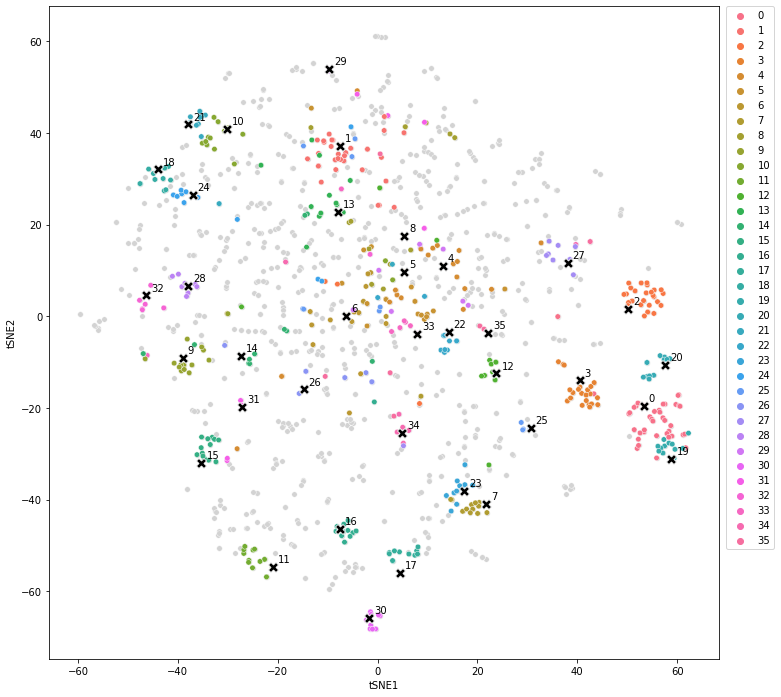

In [47]:
df.loc[:, "Cluster"] = np.NaN
df.loc[:, "Cluster_Center"] = False
for cluster_idx, cluster in enumerate(clusters):
        for i, mol_idx in enumerate(cluster):
                df.loc[:, "Cluster"].iloc[mol_idx] = cluster_idx
df.loc[:, "Cluster_Center"].iloc[pickIndices] = True

# ECFP fingerprints tsne
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=20, metric='jaccard')
xy = tsne.fit_transform(np.array(fps))

df['X'], df['Y'] = xy[:, 0], xy[:, 1]

plt.figure(figsize=(12, 12))
ax = sns.scatterplot(data=df, x="X", y="Y", s=30, color="lightgrey")
sns.scatterplot(data=df[(df.Cluster < 36)].astype({'Cluster': 'int32'}), x="X", y="Y", s=30, hue="Cluster", palette=sns.color_palette("husl", 36))

# sns.scatterplot(data=df[df.Cluster_Center == False], x='X', y='Y', hue='Cluster',s = 30)
sns.scatterplot(data=df[(df.Cluster_Center) & (df.Cluster < 36)], x='X', y='Y',
                color='black', marker = 'X', s = 100)

cluster010 = df[(df.Cluster_Center) & (df.Cluster < 36)].astype({'Cluster': 'int32'})
for i in range(36):
    plt.gca().annotate(cluster010["Cluster"].iloc[i], (cluster010["X"].iloc[i]+1, cluster010["Y"].iloc[i]+1), size=10)
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)


plt.savefig(f'{base_dir}/figures/dataset/clustering/Leader/tsne_clustering.png', dpi=300, bbox_extra_artists=(ax, lgd), bbox_inches='tight')
plt.show()
plt.close()

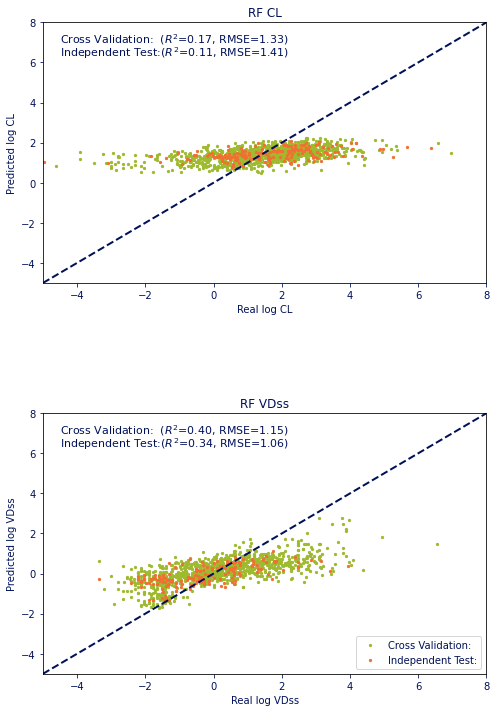

In [19]:


def QSKR_REG_scatterplot(infolder, targets, models, out=None):
    """
    Function to plot the results of regression models. Plot predicted pX vs real pX. 
    """
    my_cmap = ["#9EBA2E", "#F46E32"]

    plt.figure(figsize=(7, 10))
    for i, target in enumerate(targets):
        cate = ['cv', 'ind']
        for m, model in enumerate(models):
            plt.subplot(len(targets),len(models),1 + i*len(models) + m)
            for j, legend in enumerate(['Cross Validation:  ', 'Independent Test:']):
                df = pd.read_table('%s/%s_REG_%s.%s.tsv' % (infolder, model, target, cate[j]))
                plt.scatter(df.Label, df.Score, s=5, label=legend, color=my_cmap[j])
                coef = metrics.r2_score(df.Label, df.Score)
                rmse = metrics.mean_squared_error(df.Label, df.Score, squared=False)
                # print('%s %s:(R^2=%.2f, RMSE=%.2f)' % (model, legend,coef,rmse))
                plt.annotate('%s($R^2$=%.2f, RMSE=%.2f)' % (legend,coef,rmse), xy=[-4.5,7-0.7*j], fontsize=11)

            plt.title('%s %s' % (model,target))
            plt.xlim([-5, 8])
            plt.ylim([-5, 8])
            plt.xlabel(f"Real log {target}")
            plt.ylabel(f"Predicted log {target}")
            plt.plot([-5, 8], [-5, 8], color='#001158', lw=2, linestyle='--')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.3, hspace = 0.5) 
    if out is None:
        plt.show()
    else:
        plt.savefig(out, dpi=300)

QSKR_REG_scatterplot(f"{base_dir}/envs/",
                     ["CL", "VDss"], 
                     ["RF"],
                      out=f"{base_dir}/figures/QSKR_REG_scatterplot.png")

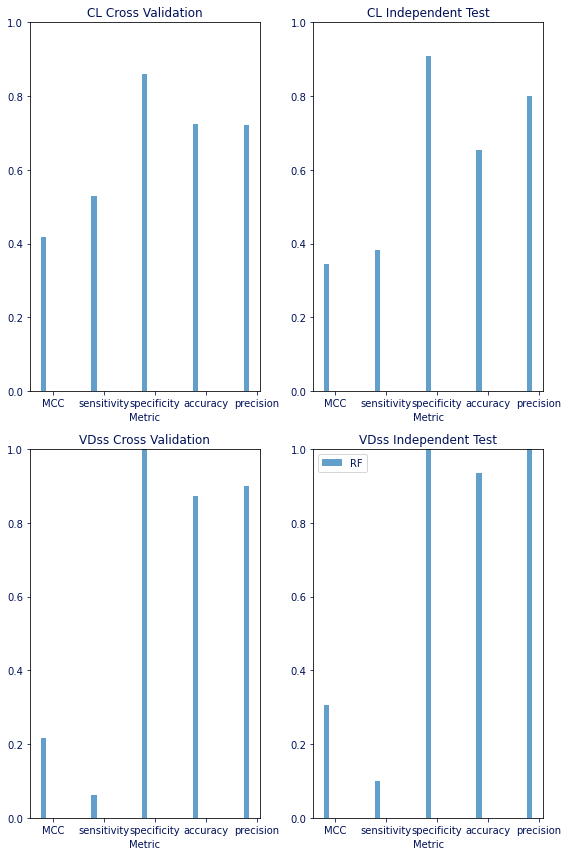

In [20]:
def QSKR_CLS_metrics(infolder, targets, models, out=None):
    """
    Function to plot the results of classification models with different metrics (MCC, Sensitivity, specificity, accuracy) 
    """
    plt.figure(figsize=(8, 12))
    for i, target in enumerate(targets):
        cate = ['cv', 'ind']
        mymetrics = ['MCC', 'sensitivity', 'specificity', 'accuracy', 'precision']
        barWidth = 0.1
        for j, legend in enumerate(['Cross Validation', 'Independent Test']):
            plt.subplot(len(targets),2,1 + i*2 + j)
            for k, model in enumerate(models):
                df = pd.read_table('%s/%s_CLS_%s.%s.tsv' % (infolder, model, target, cate[j]))
                df.Score = df.Score>0.5
                MCC = metrics.matthews_corrcoef(df.Label, df.Score)
                SEN = metrics.recall_score(df.Label, df.Score)
                CM = metrics.confusion_matrix(df.Label, df.Score)
                SPE = CM[0,0]/(CM[0,1]+CM[0,0]) # TN/(FP+TN)
                ACC = metrics.accuracy_score(df.Label, df.Score)
                PRE = metrics.precision_score(df.Label, df.Score)
                pos = [x + barWidth * k + barWidth * 0.3 * j for x in np.arange(len(mymetrics))]
                plt.bar(pos, [MCC,SEN,SPE,ACC,PRE], width = barWidth, label=model, alpha=0.7)
            plt.title('%s %s' % (target,legend))
            plt.xticks([x + barWidth * 2 for x in np.arange(len(mymetrics))], mymetrics)
            plt.ylim((0,1))
            plt.xlabel('Metric')
    plt.legend(loc='upper left')
    plt.tight_layout()
    if out is None:
        plt.show()
    else:
        plt.savefig(out, dpi=300)

QSKR_CLS_metrics(f"{base_dir}/envs/",
                     ["CL", "VDss"], 
                     ["RF"],
                      out=f"{base_dir}/figures/QSKR_CLS_metrics.png")


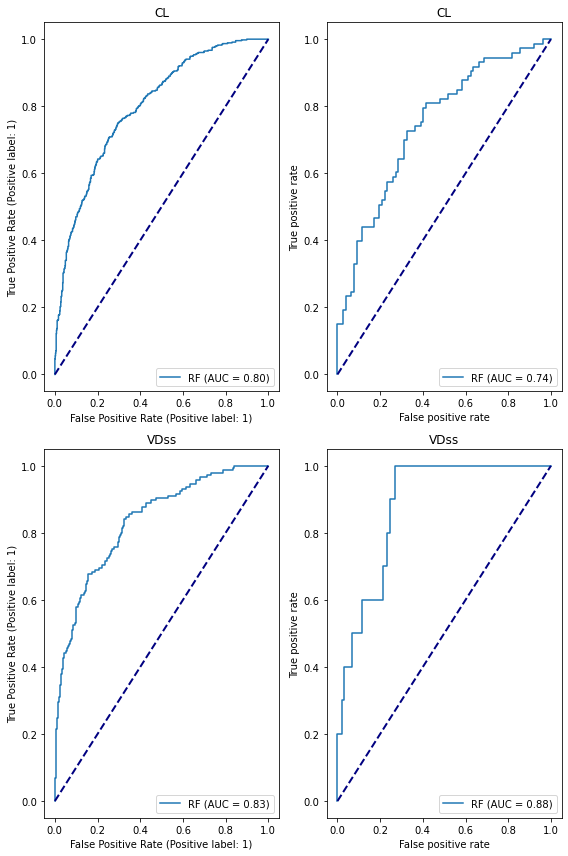

In [45]:
def QSKR_CLS_ROC(infolder, targets, models, out=None):
    """
    Function to plot the results of classification models in a ROC curve.
    """
    plt.figure(figsize=(8, 12))
    for i, target in enumerate(targets):
        cate = ['cv', 'ind']
        for j, legend in enumerate(['Cross Validation', 'Independent Test']):
            plt.subplot(len(targets),2,1 + i*2 + j)
            for model in models:
                df = pd.read_table('%s/%s_CLS_%s.%s.tsv' % (infolder, model, target, cate[j]))
                ax = plt.gca()
                metrics.RocCurveDisplay.from_predictions(df.Label, df.Score, ax = ax, name="%s" % model)
            plt.title(target)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
    #ax.legend(handles, labels, loc='lower right')
    plt.tight_layout()
    if out is None:
        plt.show()
    else:
        plt.savefig(out, dpi=300, bbox_inches='tight')

QSKR_CLS_ROC(f"{base_dir}/envs/",
                     ["CL", "VDss"], 
                     ["RF"],
                      out=f"{base_dir}/figures/QSKR_CLS_ROC.png")


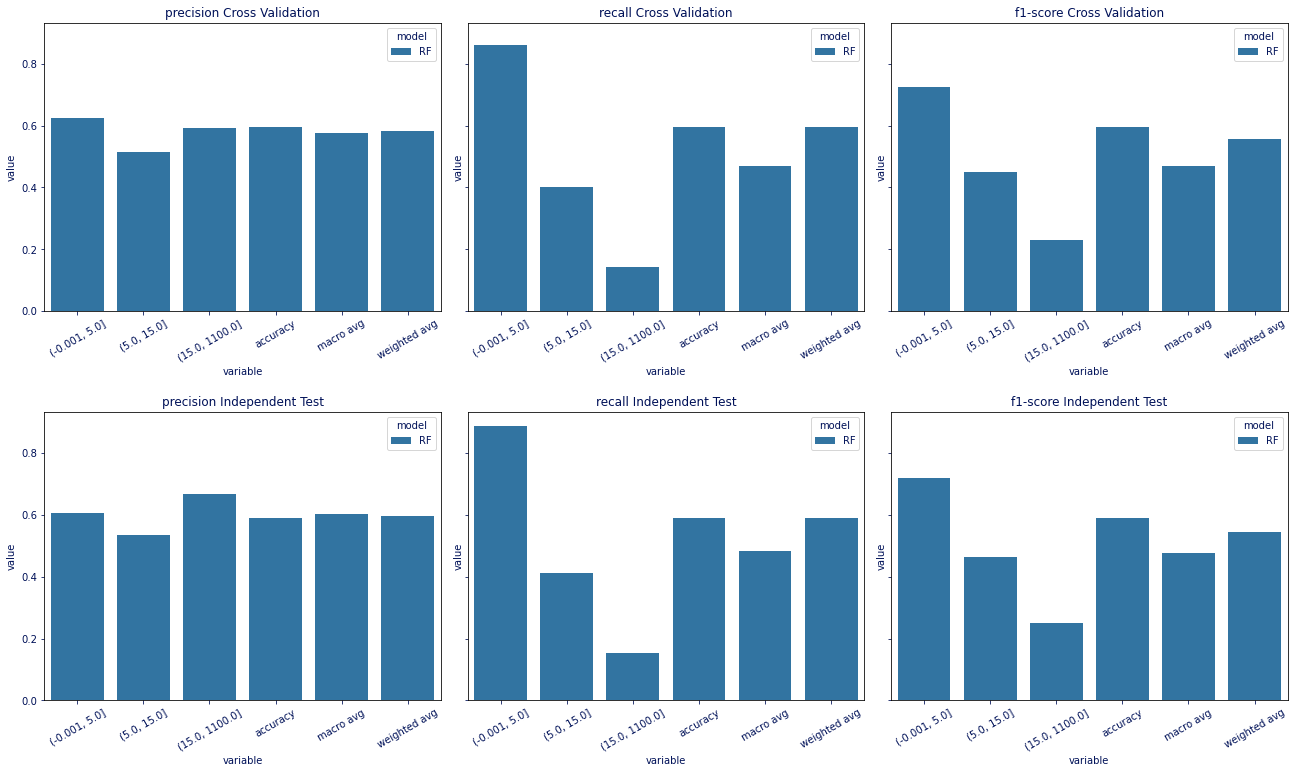

In [90]:
from IPython import display
from sklearn.metrics import classification_report
import pandas as pd

def QSKR_CLS_metrics_multi(base_dir, property, models, out=None):
    data = pickle.load(open(f'{base_dir}/{property}_CLS_QSKRdata.pkg', 'rb'))
    labels = [str(interval) for interval in data.df.CL.cat.categories]
    cate = ["cv", "ind"]
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
    fig.tight_layout(h_pad=8)
    for i, legend in enumerate(['Cross Validation', 'Independent Test']):
        reports = []
        for model in models:
            df = pd.read_table(f'{base_dir}/{model}_CLS_{property}.{cate[i]}.tsv', sep='\t')
            report = classification_report(df['Label'], df['Score'], target_names = labels, output_dict=True)
            report = pd.DataFrame(report).melt(ignore_index=False).rename_axis('metric').reset_index()
            reports.append(report)
        result = pd.concat(reports, keys=models).droplevel(level=1).rename_axis(['model']).reset_index()
        for j, metric in enumerate(["precision", "recall", "f1-score"]):
            axes[i, j].set_title(f"{metric} {legend}")
            axes[i, j].tick_params(axis='x', rotation=30)
            sns.barplot(ax=axes[i, j], data=result[result.metric==metric], x="variable", y="value", hue="model")

QSKR_CLS_metrics_multi(f"{base_dir}/envs/",
                     "CL", 
                     ["RF"],
                      out=f"{base_dir}/figures/QSKR_CLS_multi_metrics.png")